### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

## recreating CLQ

In [4]:
tmeshf = './corinneData/mesh_mask_v2.3.nc'
C14d_qtr_c14f = './corinneData/C14d_1950_2014_qtr_c14.nc'
C14d_Cflxf = './corinneData/C14d_1950_2014_Cflx.nc'

C14c_qtr_c14f = './corinneData/C14c_1950_2014_qtr_c14.nc'
C14c_Cflxf = './corinneData/C14c_1950_2014_Cflx.nc'
dc14dzf = './corinneData/dc14dz.nc' ### corinne says this is momb carbon 

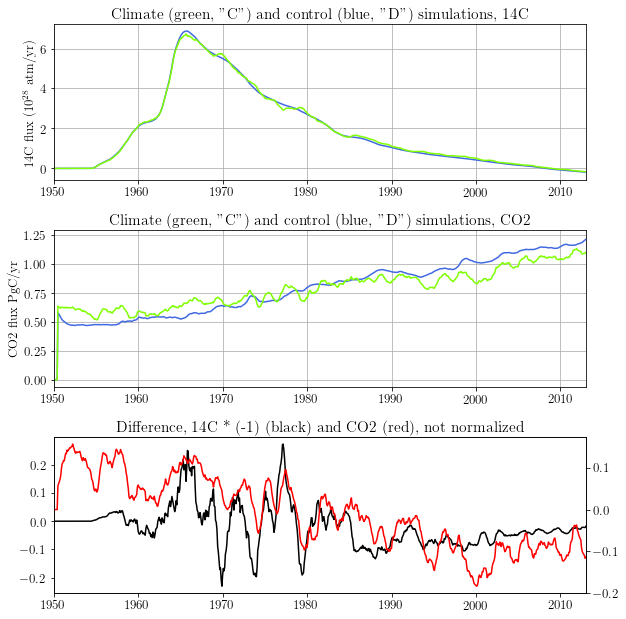

In [5]:
#### ------ A) load data
tmesh = xr.open_dataset(tmeshf)
#climate run
C14d_qtr_c14 = xr.open_dataset(C14d_qtr_c14f)
C14d_Cflx = xr.open_dataset(C14d_Cflxf)
#control run 
C14c_qtr_c14 = xr.open_dataset(C14c_qtr_c14f)
C14c_Cflx = xr.open_dataset(C14c_Cflxf)
#vertical gradient:
dc14dz  = xr.open_dataset(dc14dzf)

#### -------- B) get areas/grid variables
tmask = tmesh.tmask[0,0,:,:] 
area = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
tarea = np.nansum(area)
vol = area * tmesh.e3t_0[0,0]

##### ------ C) "regridding", ie fix the timestamp
times = pd.date_range("1950/01/01","2014/12/01",freq='MS')

qtrnewt_C = C14c_qtr_c14.qtr_c14 * tmask.values
qtrnewt_C['time_counter'] = times
cflxnewt_C = C14c_Cflx.Cflx * tmask.values
cflxnewt_C['time_counter'] = times

qtrnewt_D = C14d_qtr_c14.qtr_c14 * tmask.values
qtrnewt_C['time_counter'] = times
cflxnewt_D = C14d_Cflx.Cflx * tmask.values
cflxnewt_C['time_counter'] = times


##### ------ D) fluxes
### QQ why volume/10, why not area, wouldn't it be same?
### QQ why these units?/conversion factors?
qtrflx_C = qtrnewt_C * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_C = cflxnewt_C *area.values*3.156e7 
qtrflx_D = qtrnewt_D * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_D = cflxnewt_D *area.values*3.156e7 


fact = 1.1
fig, axs = plt.subplots(3,1, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


qtrflx_mn_C = qtrflx_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
qtrflx_mn_D = qtrflx_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C, color = 'royalblue')
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_D, color = 'chartreuse')


cflxint_mn_C = cflxint_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
cflxint_mn_D = cflxint_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 

axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C, color = 'royalblue')
axs[1].plot(qtrflx_C.time_counter, cflxint_mn_D, color = 'chartreuse')

ax3 = axs[2]
ax3b = ax3.twinx()
ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1, color = 'k')
ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C.values, color = 'r')

axs[0].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
axs[1].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))

axs[0].set_title('Climate (green, "C") and control (blue, "D") simulations, 14C')
axs[1].set_title('Climate (green, "C") and control (blue, "D") simulations, CO2')
axs[2].set_title('Difference, 14C * (-1) (black) and CO2 (red), not normalized')

axs[0].set_ylabel('14C flux ($10^{28}$ atm/yr)')
axs[1].set_ylabel('CO2 flux PgC/yr')


axs[0].grid()
axs[1].grid()

plt.tight_layout()
plt.show()

## add normalization

    Therefore to be able to use 14C to infer changes in CO2, we need first to correct for the
    changing vertical gradient of 14C. This can be done easily by normalising the 14C fluxes to the
    vertical gradient, so that 14C-normalised = 14C/dc14dz*1 (with 1 being an arbitrary relative
    dc14dz ratio, e.g. that of year 2010).



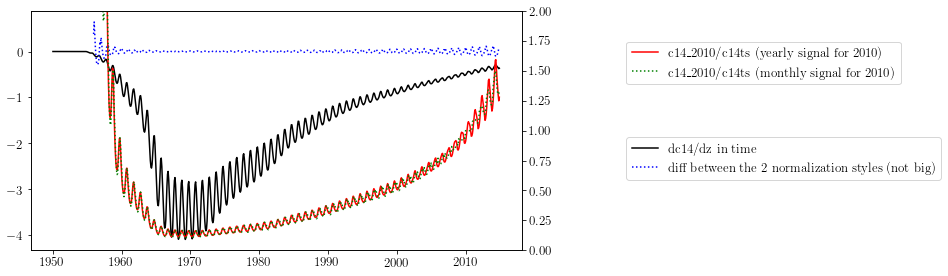

In [6]:
normy = 2010

fact = 1.1
fig, axs = plt.subplots(1,1, figsize=(8*fact, 4*fact), facecolor='w', edgecolor='k')
#axs = axs.ravel()

dc14dzf = './corinneData/dc14dz.nc'
CLQ_dc14dz  = xr.open_dataset(dc14dzf)
times = pd.date_range("1950/01/01","2014/12/01",freq='MS')
CLQ_dc14dz['TIME_COUNTER'] = times

#dc14/dz
axs.plot(CLQ_dc14dz.TIME_COUNTER,CLQ_dc14dz.DC14DZ, color = 'k', label = 'dc14/dz in time')


# yearly avg for year 2010 - normsig1
norm = np.mean(CLQ_dc14dz.DC14DZ.sel(TIME_COUNTER=slice(f'{normy}-01-01', f'{normy}-12-31')).values)
DC14DZ = np.squeeze(CLQ_dc14dz.DC14DZ.values); DC14DZ[np.where(DC14DZ == 0)] = np.nan
normsig1 = np.squeeze(norm/DC14DZ) 
axs2 = axs.twinx()
axs2.plot(CLQ_dc14dz.TIME_COUNTER,normsig1, color = 'r', label = 'c14_2010/c14ts (yearly signal for 2010)')

# monthly avg for year 2010 - normsig 
norm = np.squeeze(CLQ_dc14dz.DC14DZ.sel(TIME_COUNTER=slice(f'{normy}-01-01', f'{normy}-12-31')).values)
repeats = 780 // 12
normt = np.tile(norm, repeats)
normsig = normt/DC14DZ
normsig[normsig > 10 ] = np.nan

axs2.plot(CLQ_dc14dz.TIME_COUNTER,normsig, color = 'g', linestyle = ':', label = 'c14_2010/c14ts (monthly signal for 2010)')
axs.plot(CLQ_dc14dz.TIME_COUNTER,normsig-normsig1, color = 'b', linestyle = ':', label = 'diff between the 2 normalization styles (not big)')
axs2.set_ylim([0,2])

axs.legend(bbox_to_anchor = [1.2,0.5])
axs2.legend(bbox_to_anchor = [1.2,0.9])
# plt.title('bomb c14 gradient in CLQ run')
# CL

In [7]:
# #### ------ A) load data
# tmesh = xr.open_dataset(tmeshf)
# #climate run
# C14d_qtr_c14 = xr.open_dataset(C14d_qtr_c14f)
# C14d_Cflx = xr.open_dataset(C14d_Cflxf)
# #control run 
# C14c_qtr_c14 = xr.open_dataset(C14c_qtr_c14f)
# C14c_Cflx = xr.open_dataset(C14c_Cflxf)
# #vertical gradient:
# dc14dz  = xr.open_dataset(dc14dzf)

# #### -------- B) get areas/grid variables
# tmask = tmesh.tmask[0,0,:,:] 
# area = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
# tarea = np.nansum(area)
# vol = area * tmesh.e3t_0[0,0]

# ##### ------ C) "regridding", ie fix the timestamp
# times = pd.date_range("1950/01/01","2014/12/01",freq='MS')

# qtrnewt_C = C14c_qtr_c14.qtr_c14 * tmask.values
# qtrnewt_C['time_counter'] = times
# cflxnewt_C = C14c_Cflx.Cflx * tmask.values
# cflxnewt_C['time_counter'] = times

# qtrnewt_D = C14d_qtr_c14.qtr_c14 * tmask.values
# qtrnewt_C['time_counter'] = times
# cflxnewt_D = C14d_Cflx.Cflx * tmask.values
# cflxnewt_C['time_counter'] = times


# ##### ------ D) fluxes
# ### QQ why volume/10, why not area, wouldn't it be same?
# ### QQ why these units?/conversion factors?
# qtrflx_C = qtrnewt_C * (1/10) *2 *1e-14 *vol.values * 3.156e7
# cflxint_C = cflxnewt_C *area.values*3.156e7 
# qtrflx_D = qtrnewt_D * (1/10) *2 *1e-14 *vol.values * 3.156e7
# cflxint_D = cflxnewt_D *area.values*3.156e7 


# fact = 1.1
# fig, axs = plt.subplots(4,1, figsize=(8*fact, 8*1.33*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()


# qtrflx_mn_C = qtrflx_C.rolling(time_counter=12, center=True).mean()\
# .sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
# qtrflx_mn_D = qtrflx_D.rolling(time_counter=12, center=True).mean()\
# .sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
# axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C, color = 'royalblue')
# axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_D, color = 'chartreuse')


# cflxint_mn_C = cflxint_C.rolling(time_counter=12, center=True).mean()\
# .sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
# cflxint_mn_D = cflxint_D.rolling(time_counter=12, center=True).mean()\
# .sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 

# axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C, color = 'royalblue')
# axs[1].plot(qtrflx_C.time_counter, cflxint_mn_D, color = 'chartreuse')


# #
# ax3 = axs[2]
# ax3b = ax3.twinx()
# ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1, color = 'k')
# ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C.values, color = 'r')

# ax4 = axs[3]
# ax4b = ax4.twinx()
# ax4.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1*normsig, color = 'k')
# ax4b.plot(qtrflx_C.time_counter, (cflxint_mn_D.values-cflxint_mn_C.values), color = 'r')
# ax4.set_ylim([-0.15,0.1])


# axs[0].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
# axs[1].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
# ax3.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
# ax3b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
# ax4.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
# ax4b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))



# axs[0].set_title('Climate (green, "C") and control (blue, "D") simulations, 14C')
# axs[1].set_title('Climate (green, "C") and control (blue, "D") simulations, CO2')
# axs[2].set_title('Difference, 14C * (-1) (black) and CO2 (red), not normalized')
# axs[3].set_title('Difference, 14C * (-1) (black) and CO2 (red), normalized')

# axs[0].set_ylabel('14C flux ($10^{28}$ atm/yr)')
# axs[1].set_ylabel('CO2 flux PgC/yr')


# axs[0].grid()
# axs[1].grid()

# plt.tight_layout()
# plt.show()

## recreate correlation

The Pearson correlation coefficient (r value) is: 0.7625785836861104


Text(0.5, 1.0, 'CLQ cflx diff vs c14 flx diff, r value is 0.7625785836861104')

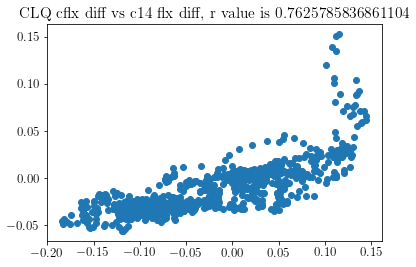

In [8]:
flxdiff = cflxint_mn_D.values-cflxint_mn_C.values
c14diff = (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1*normsig

plt.figure()
plt.scatter(flxdiff[72:-1],c14diff[72:-1])



from scipy.stats import pearsonr

# Example data 
x = flxdiff[72:-1]  # Replace with your actual data
y = c14diff[72:-1]  # Replace with your actual data

# Calculate the Pearson correlation coefficient
r_value, p_value = pearsonr(x, y)

print(f"The Pearson correlation coefficient (r value) is: {r_value}")
plt.title(f'CLQ cflx diff vs c14 flx diff, r value is {r_value}')

In [9]:
# 

## get out relevant variables from mfdataset for easier handling. 

In [10]:
yrst = 1940; yrend = 2022
extract = False
if extract:
    def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/data/greenocean/software/runs/'):
        yrs = np.arange(yrst,yrend+1,1)
        ylist = []
        for i in range(0,len(yrs)):
            ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
            t2 = glob.glob(ty)
            #print(t2)
            ylist.append(t2[0])
        return ylist



    GEA4_diad = xr.open_mfdataset(make_yearlist(yrst,yrend,'diad_T','TOM12_TJ_GEA4'))
    GEC4_diad = xr.open_mfdataset(make_yearlist(yrst,yrend,'diad_T','TOM12_TJ_GEC4'))

    GEA4_diad.qtrB14b.to_netcdf(f'./GCBdata/GEA4_{yrst}_{yrend}_qtrB14b.nc')
    GEC4_diad.qtrB14b.to_netcdf(f'./GCBdata/GEC4_{yrst}_{yrend}_qtrB14b.nc')
    GEA4_diad.Cflx.to_netcdf(f'./GCBdata/GEA4_{yrst}_{yrend}_Cflx.nc')
    GEC4_diad.Cflx.to_netcdf(f'./GCBdata/GEC4_{yrst}_{yrend}_Cflx.nc')

## from recreate CLQ-c14ferret

In [11]:
#### ------ A) load data
tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
tmesh = xr.open_dataset(tmeshf)
C14d_qtr_c14 = xr.open_dataset(f'./GCBdata/GEA4_{yrst}_{yrend}_qtrB14b.nc')   ##static
C14d_Cflx = xr.open_dataset(f'./GCBdata/GEA4_{yrst}_{yrend}_Cflx.nc') ###static

C14c_qtr_c14 = xr.open_dataset(f'./GCBdata/GEC4_{yrst}_{yrend}_qtrB14b.nc')
C14c_Cflx = xr.open_dataset(f'./GCBdata/GEC4_{yrst}_{yrend}_Cflx.nc')

times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')
print(len(times))
#dc14dzf = './corinneData/dc14dz.nc'

996


996


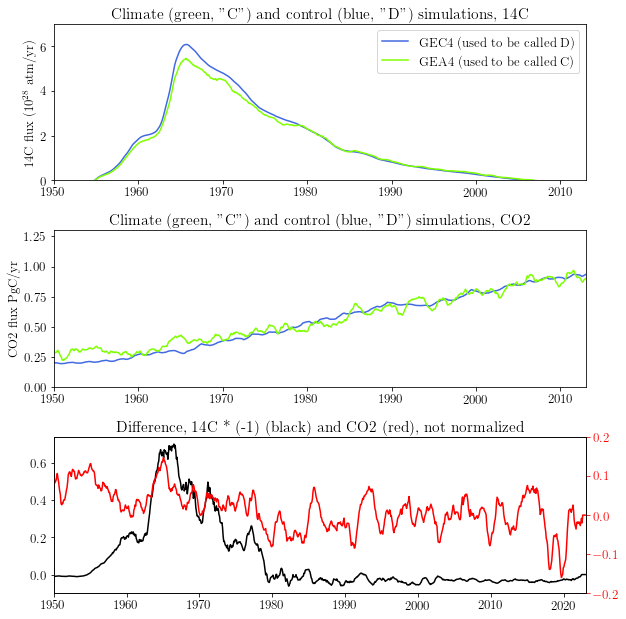

In [12]:
#### ------ A) load data
tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
tmesh = xr.open_dataset(tmeshf)
C14d_qtr_c14 = xr.open_dataset(f'./GCBdata/GEA4_{yrst}_{yrend}_qtrB14b.nc')   ##static
C14d_Cflx = xr.open_dataset(f'./GCBdata/GEA4_{yrst}_{yrend}_Cflx.nc') ###static

C14c_qtr_c14 = xr.open_dataset(f'./GCBdata/GEC4_{yrst}_{yrend}_qtrB14b.nc')
C14c_Cflx = xr.open_dataset(f'./GCBdata/GEC4_{yrst}_{yrend}_Cflx.nc')

times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')
print(len(times))
#dc14dzf = './corinneData/dc14dz.nc'

#### -------- B) get areas/grid variables
tmask = tmesh.tmask[0,0,:,:] 
area = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
tarea = np.nansum(area)
vol = area * tmesh.e3t_0[0,0]
tarea2 = np.nansum(vol)/10
# print(tarea)
# print(tarea2)

##### ------ C) "regridding", ie fix the timestamp

qtrnewt_C = C14c_qtr_c14.qtrB14b * tmask.values
cflxnewt_C = C14c_Cflx.Cflx * tmask.values
qtrnewt_D = C14d_qtr_c14.qtrB14b * tmask.values
cflxnewt_D = C14d_Cflx.Cflx * tmask.values

qtrnewt_C['time_counter'] = times
qtrnewt_D['time_counter'] = times
cflxnewt_C['time_counter'] = times
cflxnewt_D['time_counter'] = times


##### ------ D) fluxes
### QQ why volume/10, why not area, wouldn't it be same?
### QQ why these units?/conversion factors?
qtrflx_C = qtrnewt_C * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_C = cflxnewt_C *area.values*3.156e7 
qtrflx_D = qtrnewt_D * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_D = cflxnewt_D *area.values*3.156e7 


fact = 1.1
fig, axs = plt.subplots(3,1, figsize=(8*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


qtrflx_mn_C = qtrflx_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
qtrflx_mn_D = qtrflx_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C, color = 'royalblue', label = 'GEC4 (used to be called D)')
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_D, color = 'chartreuse', label = 'GEA4 (used to be called C)')
axs[0].legend()

cflxint_mn_C = cflxint_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
cflxint_mn_D = cflxint_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 

axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C, color = 'royalblue')
axs[1].plot(qtrflx_C.time_counter, cflxint_mn_D, color = 'chartreuse')

ax3 = axs[2]
ax3b = ax3.twinx()
ax3b.tick_params(axis='y', colors='red')
ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1, color = 'k')
ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C.values, color = 'r')


axs[0].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
axs[1].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2023-01-01'))
ax3b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2023-01-01'))

axs[0].set_title('Climate (green, "C") and control (blue, "D") simulations, 14C')
axs[1].set_title('Climate (green, "C") and control (blue, "D") simulations, CO2')
axs[2].set_title('Difference, 14C * (-1) (black) and CO2 (red), not normalized')

axs[0].set_ylabel('14C flux ($10^{28}$ atm/yr)')
axs[1].set_ylabel('CO2 flux PgC/yr')


axs[0].set_ylim([0,7])
axs[1].set_ylim([0,1.3])
# ax3.set_ylim([-0.4,0.4])
ax3b.set_ylim([-0.2,0.2])

plt.tight_layout()
plt.show()

## create normsig for our data 

In [13]:
def make_yearlist(yrst, yrend,rnam):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]
        ty = f'/gpfs/home/mep22dku/scratch/C14/GCBdata/grad/{rnam}_dc14dz_y{yr}.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

GEA4_c = xr.open_mfdataset(make_yearlist(1940,2022,'GEA4'))
GEC4_c = xr.open_mfdataset(make_yearlist(1940,2022,'GEC4'))

996


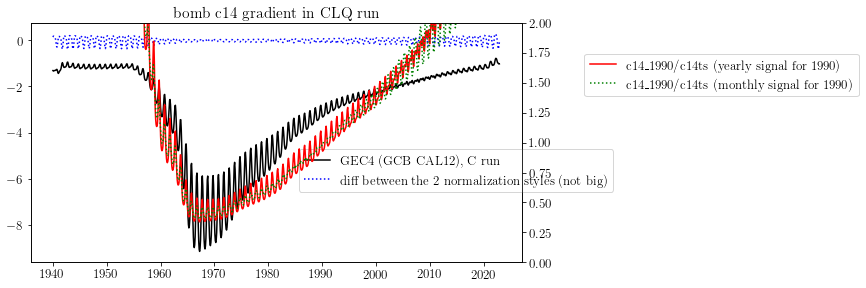

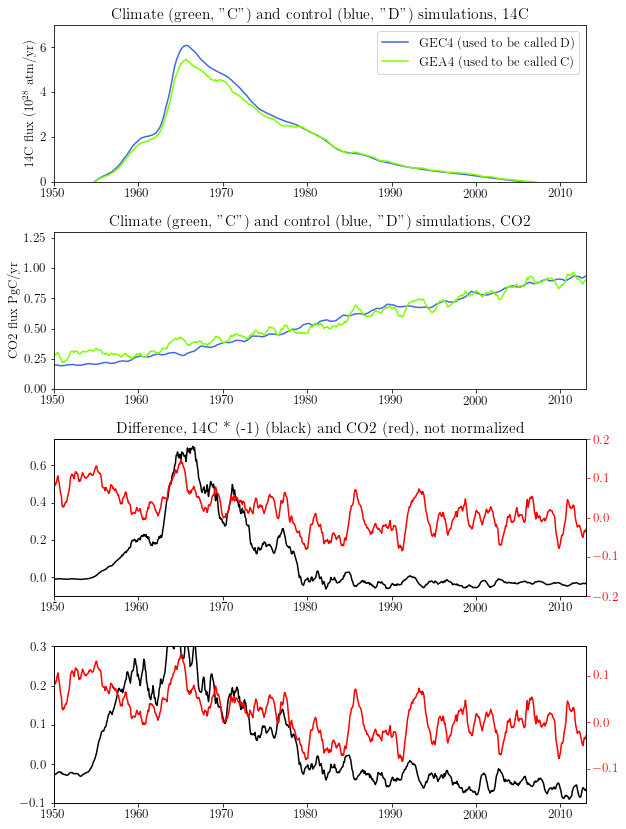

ok, also, now the r2
The Pearson correlation coefficient (r value) is: 0.5631857043238939
The Pearson correlation coefficient (r value) is: 0.5631857043238939


Text(0.5, 1.0, 'GEA4 cflx diff vs c14 flx diff, normy 1990 r value is 0.5631857043238939')

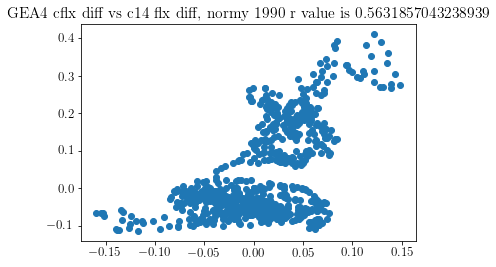

In [14]:
normy = 1990
yen = 20
fact = 1.1
fig, axs = plt.subplots(1,1, figsize=(8*fact, 4*fact), facecolor='w', edgecolor='k')
#axs = axs.ravel()

# times = GEC4_c.indexes['time_counter'].to_datetimeindex()

times = pd.date_range("1940/01/01","2022/12/31",freq='MS')
tl = (len(times))
GEC4_c['time_counter'] = times

axs.plot(times, GEC4_c.DC14DZ, label = 'GEC4 (GCB CAL12), C run', color = 'k')
norm = np.mean(GEC4_c.DC14DZ.sel(time_counter=slice(f'{normy}-01-01', f'{normy}-12-31')).values)

DC14DZ = np.squeeze(GEC4_c.DC14DZ.values); DC14DZ[np.where(DC14DZ == 0)] = np.nan
normsig1 = np.squeeze(norm/DC14DZ) 
axs2 = axs.twinx()
axs2.plot(times,normsig1, color = 'r', label = f'c14_{normy}/c14ts (yearly signal for {normy})')

# monthly avg for year 2010 - normsig 
norm = np.squeeze(GEC4_c.DC14DZ.sel(time_counter=slice(f'{normy}-01-01', f'{normy}-12-31')).values)
repeats = tl // 12
normt = np.tile(norm, repeats)
normsig = normt/DC14DZ
normsig[normsig > 10 ] = np.nan

axs2.plot(times,normsig, color = 'g', linestyle = ':', label = f'c14_{normy}/c14ts (monthly signal for {normy})')
axs.plot(times,normsig-normsig1, color = 'b', linestyle = ':', label = f'diff between the 2 normalization styles (not big)')
axs2.set_ylim([0,2])

axs.legend(bbox_to_anchor = [1.2,0.5])
axs2.legend(bbox_to_anchor = [1.7,0.9])
plt.title('bomb c14 gradient in CLQ run')
# CL



#### ------ A) load data
tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
tmesh = xr.open_dataset(tmeshf)
C14d_qtr_c14 = xr.open_dataset(f'./GCBdata/GEA4_{yrst}_{yrend}_qtrB14b.nc')   ##static
C14d_Cflx = xr.open_dataset(f'./GCBdata/GEA4_{yrst}_{yrend}_Cflx.nc') ###static

C14c_qtr_c14 = xr.open_dataset(f'./GCBdata/GEC4_{yrst}_{yrend}_qtrB14b.nc')
C14c_Cflx = xr.open_dataset(f'./GCBdata/GEC4_{yrst}_{yrend}_Cflx.nc')

times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')
print(len(times))
#dc14dzf = './corinneData/dc14dz.nc'

#### -------- B) get areas/grid variables
tmask = tmesh.tmask[0,0,:,:] 
area = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
tarea = np.nansum(area)
vol = area * tmesh.e3t_0[0,0]
tarea2 = np.nansum(vol)/10
# print(tarea)
# print(tarea2)

##### ------ C) "regridding", ie fix the timestamp

qtrnewt_C = C14c_qtr_c14.qtrB14b * tmask.values
cflxnewt_C = C14c_Cflx.Cflx * tmask.values
qtrnewt_D = C14d_qtr_c14.qtrB14b * tmask.values
cflxnewt_D = C14d_Cflx.Cflx * tmask.values

qtrnewt_C['time_counter'] = times
qtrnewt_D['time_counter'] = times
cflxnewt_C['time_counter'] = times
cflxnewt_D['time_counter'] = times


##### ------ D) fluxes
### QQ why volume/10, why not area, wouldn't it be same?
### QQ why these units?/conversion factors?
qtrflx_C = qtrnewt_C * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_C = cflxnewt_C *area.values*3.156e7 
qtrflx_D = qtrnewt_D * (1/10) *2 *1e-14 *vol.values * 3.156e7
cflxint_D = cflxnewt_D *area.values*3.156e7 


fact = 1.1
fig, axs = plt.subplots(4,1, figsize=(8*fact, 8*1.33*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


qtrflx_mn_C = qtrflx_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
qtrflx_mn_D = qtrflx_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*6.023e23*1e-26
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_C, color = 'royalblue', label = 'GEC4 (used to be called D)')
axs[0].plot(qtrflx_C.time_counter, qtrflx_mn_D, color = 'chartreuse', label = 'GEA4 (used to be called C)')
axs[0].legend()

cflxint_mn_C = cflxint_C.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 
cflxint_mn_D = cflxint_D.rolling(time_counter=12, center=True).mean()\
.sel(y=slice(0,47)).sum(dim = ['x','y'])*12e-15 

axs[1].plot(qtrflx_C.time_counter, cflxint_mn_C, color = 'royalblue')
axs[1].plot(qtrflx_C.time_counter, cflxint_mn_D, color = 'chartreuse')

ax3 = axs[2]
ax3b = ax3.twinx()
ax3b.tick_params(axis='y', colors='red')
ax3.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1, color = 'k')
ax3b.plot(qtrflx_C.time_counter, cflxint_mn_D.values-cflxint_mn_C.values, color = 'r')


ax4 = axs[3]
ax4b = ax4.twinx()
ax4b.tick_params(axis='y', colors='red')
ax4.plot(qtrflx_C.time_counter, (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1*normsig, color = 'k')
ax4b.plot(qtrflx_C.time_counter, (cflxint_mn_D.values-cflxint_mn_C.values), color = 'r')
ax4.set_ylim([-0.1,0.3])



axs[0].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
axs[1].set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax3b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax4.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))
ax4b.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2013-01-01'))

axs[0].set_title('Climate (green, "C") and control (blue, "D") simulations, 14C')
axs[1].set_title('Climate (green, "C") and control (blue, "D") simulations, CO2')
axs[2].set_title('Difference, 14C * (-1) (black) and CO2 (red), not normalized')

axs[0].set_ylabel('14C flux ($10^{28}$ atm/yr)')
axs[1].set_ylabel('CO2 flux PgC/yr')


axs[0].set_ylim([0,7])
axs[1].set_ylim([0,1.3])
# ax3.set_ylim([-0.4,0.4])
ax3b.set_ylim([-0.2,0.2])

plt.tight_layout()
plt.show()


print('ok, also, now the r2')


flxdiff = cflxint_mn_D.values-cflxint_mn_C.values
c14diff = (qtrflx_mn_D.values-qtrflx_mn_C.values)*-1*normsig

plt.figure()

soy = 192 #remove first 16 years, start at 1956

plt.scatter(flxdiff[soy:-1],c14diff[soy:-1])


from scipy.stats import pearsonr

# Example data 
x = flxdiff[soy:-1]  # Replace with your actual data
y = c14diff[soy:-1]  # Replace with your actual data

# Calculate the Pearson correlation coefficient
r_value, p_value = pearsonr(x, y)

print(f"The Pearson correlation coefficient (r value) is: {r_value}")
# Calculate the Pearson correlation coefficient
r_value, p_value = pearsonr(x, y)

print(f"The Pearson correlation coefficient (r value) is: {r_value}")
plt.title(f'GEA4 cflx diff vs c14 flx diff, normy {normy} r value is {r_value}')

In [15]:
len(cflxint_mn_D)

996